# Video metrics

In [3]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import math
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import subprocess
import csv
import seaborn as sns

## Ground truth

In [15]:
TEST_SET_PATH = '/home/rodri/Downloads/Videos/dataset/'                
test_labels = '/home/rodri/Downloads/Videos/dataset/metadata.csv'
df_labels = pd.read_csv(test_labels)

## Predictions

In [9]:
## Model variables
ROBOFLOW_MODELS = [
    'yolov5s_batch_8', # 1
    'yolov5s_batch_16', # 2 
    'yolov5s_batch_32', # 3 
    'yolov8s', # 4
    'no_version', # 5
    'no_version', # 6
    'error_uploading', # 7
    'yolov5s_data_augmentation', # 8
    'yolov5n_data_augmentation', # 9
]

MODEL_VERSION = 8

OUT_DATA_PATH = '/home/rodri/Downloads/Videos'

# Create and set output path
os.makedirs(os.path.join(OUT_DATA_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics'), exist_ok=True)

OUTPUT_PATH = os.path.join(OUT_DATA_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics')

In [4]:
BASE_CURL = 'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/{{MODEL_VERSION}}?api_key=DmyTMwALZb1Ah6cKptuz"'
BASE_CURL = BASE_CURL.replace('{{MODEL_VERSION}}', str(MODEL_VERSION))
BASE_CURL

'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/8?api_key=DmyTMwALZb1Ah6cKptuz"'

In [5]:
def get_annotations_from_image(image: str) -> list:
    """ Get annotations from images

    Args:
        model (ObjectDetectionModel): Model to use
        image (str): Image path to predict
        
    Returns:
        list: List of annotations
    """
    annotations = []
    annotations = subprocess.check_output(BASE_CURL.replace('${file}', image), shell=True)
    try:
        annotations = json.loads(annotations)
        annotations = annotations['predictions']
    except Exception as e:
        annotations = []
        print(f'Error: {e} in file {image}')
        raise StopIteration
        
    def convert_yolo_prediction_to_voc(annotations: list)->list:
        new_annotations = []
        try:
            assert len(annotations) > 0, 'No annotations'
            for annotation in annotations:            
                class_id = annotation['class']
                
                x = annotation['x']
                y = annotation['y']
                w = annotation['width']
                h = annotation['height']
                
                xmin = math.floor(x - (w / 2)+1)
                ymin = math.floor(y - (h / 2)+1)
                xmax = math.floor(x + (w / 2)+1)
                ymax = math.floor(y + (h / 2)+1)
                
                new_annotations.append({
                    'path': image,
                    'class': 2 if class_id == 'knife' else (1 if class_id == 'gun' else 0),
                    'bbox':{
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    },
                    'conf': annotation['confidence']
                })
            
            return new_annotations
        except AssertionError:
            return [
                {
                    'path': image,
                    'class': 0,
                    'bbox':{
                        'xmin': 0,
                        'ymin': 0,
                        'xmax': 0,
                        'ymax': 0
                    },
                    'conf': 0
                }
            ]

    return convert_yolo_prediction_to_voc(annotations)
    

# Test case
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/101516494_5781_jpg.rf.90ba3800fa4ed5e25aa2ed5b3dbbc221.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/11_12_1565_jpg.rf.95d9be65da98b4d65450e527aec902ba.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)
# image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg'
# annotations = get_annotations_from_image(image_path)
# print(annotations)

In [7]:
test_predictions = []
for path in tqdm((TEST_SET_PATH+x for x in df_labels['path']), desc='Predicting images', total=1294):
    # print('Image path:', path)
    annotations = get_annotations_from_image(os.path.join(test_labels, path))
    # print('Annotations', end=': ')
    # print(annotations)
    test_predictions.append(annotations)

Predicting images:   0%|          | 0/1294 [00:00<?, ?it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87601  100    93  100 87508     20  19011  0:00:04  0:00:04 --:--:--    27
Predicting images:   0%|          | 1/1294 [00:04<1:39:44,  4.63s/it]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79245  100    93  100 79152    193   160k --:--:-- --:--:-- --:--:--  160k
Predicting images:   0%|          | 2/1294 [00:05<47:19,  2.20s/it]    % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72617  100    93  100 72524    203   154k --:--:-- --:--:-- --:--:--  154k
Predicting images:   0%|          | 3/1294 [00:05<30:20,  1.41s/it]  % Total    % Received %

In [4]:
## Save predictions in a json file
with open(os.path.join(OUTPUT_PATH, 'test_predictions.json'), 'w') as f:
    json.dump(test_predictions, f)

NameError: name 'OUTPUT_PATH' is not defined

## Reading test_labels

In [7]:
df_labels

,path,class
0,backgrounds/background_100.jpg,0
1,backgrounds/background_101.jpg,0
2,backgrounds/background_102.jpg,0
3,backgrounds/background_103.jpg,0
4,backgrounds/background_104.jpg,0
...,...,...
473,knives/knife_5.jpg,2
474,knives/knife_6.jpg,2
475,knives/knife_7.jpg,2
476,knives/knife_8.jpg,2


In [10]:
## Read json file and convert to dataframe

with open(os.path.join(OUTPUT_PATH, 'test_predictions.json'), 'r') as f:
    test_predictions = json.load(f)
    
test_predictions = [item[0] for item in test_predictions]
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,path,class,bbox,conf
0,/home/rodri/Downloads/Videos/dataset/backgroun...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
1,/home/rodri/Downloads/Videos/dataset/backgroun...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
2,/home/rodri/Downloads/Videos/dataset/backgroun...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
3,/home/rodri/Downloads/Videos/dataset/backgroun...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
4,/home/rodri/Downloads/Videos/dataset/backgroun...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
...,...,...,...,...
473,/home/rodri/Downloads/Videos/dataset/knives/kn...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
474,/home/rodri/Downloads/Videos/dataset/knives/kn...,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
475,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,"{'xmin': 785, 'ymin': 482, 'xmax': 958, 'ymax'...",0.677
476,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,"{'xmin': 1356, 'ymin': 893, 'xmax': 1526, 'yma...",0.751


In [16]:
## Fix path from labels
df_labels['path'] = df_labels['path'].apply(lambda x: TEST_SET_PATH+x)

In [17]:
df_labels

,path,class
0,/home/rodri/Downloads/Videos/dataset/backgroun...,0
1,/home/rodri/Downloads/Videos/dataset/backgroun...,0
2,/home/rodri/Downloads/Videos/dataset/backgroun...,0
3,/home/rodri/Downloads/Videos/dataset/backgroun...,0
4,/home/rodri/Downloads/Videos/dataset/backgroun...,0
...,...,...
473,/home/rodri/Downloads/Videos/dataset/knives/kn...,2
474,/home/rodri/Downloads/Videos/dataset/knives/kn...,2
475,/home/rodri/Downloads/Videos/dataset/knives/kn...,2
476,/home/rodri/Downloads/Videos/dataset/knives/kn...,2


## Merge dataframes

In [18]:
## Merge labels and predictions
df_total = pd.merge(df_labels, test_predictions, on='path', how='left')
df_total

,path,class_x,class_y,bbox,conf
0,/home/rodri/Downloads/Videos/dataset/backgroun...,0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
1,/home/rodri/Downloads/Videos/dataset/backgroun...,0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
2,/home/rodri/Downloads/Videos/dataset/backgroun...,0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
3,/home/rodri/Downloads/Videos/dataset/backgroun...,0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
4,/home/rodri/Downloads/Videos/dataset/backgroun...,0,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
...,...,...,...,...,...
473,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
474,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,0,"{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}",0.000
475,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,2,"{'xmin': 785, 'ymin': 482, 'xmax': 958, 'ymax'...",0.677
476,/home/rodri/Downloads/Videos/dataset/knives/kn...,2,2,"{'xmin': 1356, 'ymin': 893, 'xmax': 1526, 'yma...",0.751


In [31]:
## Save dataframe
df_total.to_csv(os.path.join(OUTPUT_PATH, 'merged.csv'), index=False)

## Get video metrics

In [36]:
df_total.describe()

,class_x,class_y,conf
count,478.000000,478.000000,478.000000
mean,0.391213,0.171548,0.100308
std,0.694155,0.388334,0.230108
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,2.000000,2.000000,0.813000


In [20]:
## Classification report
classification_report = classification_report(df_total['class_x'], df_total['class_y'], output_dict=True)
classification_report = pd.DataFrame(classification_report).transpose()
classification_report

,precision,recall,f1-score,support
0,0.826633,0.942693,0.880857,349.000000
1,0.589744,0.647887,0.617450,71.000000
2,1.000000,0.034483,0.066667,58.000000
accuracy,0.788703,0.788703,0.788703,0.788703
macro avg,0.805459,0.541688,0.521658,478.000000
weighted avg,0.812483,0.788703,0.742938,478.000000


In [21]:
## Plot confusion matrix with pandas and seaborn
confusion_matrix = pd.crosstab(df_total['class_x'], df_total['class_y'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2
Actual,,,
0,329,20,0
1,25,46,0
2,44,12,2


<Axes: xlabel='Predicted', ylabel='True'>

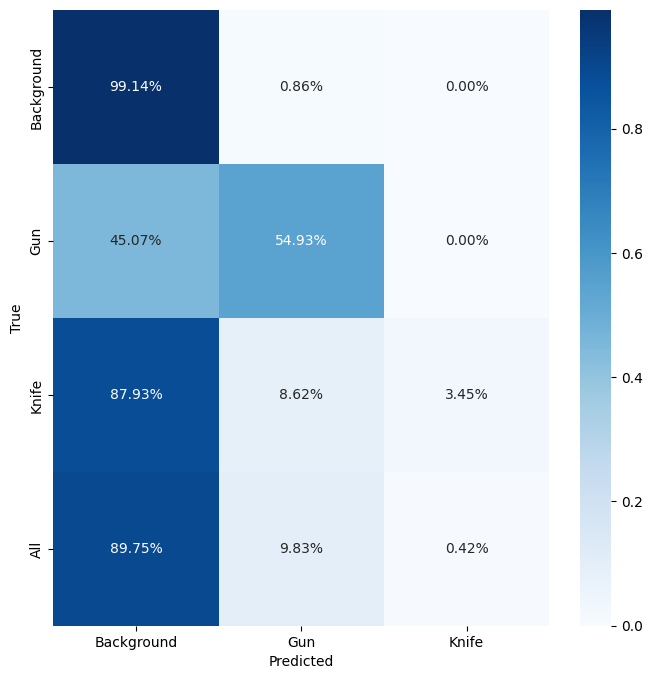

In [39]:
# Confusion matrix percentage
confusion_matrix_percentage = pd.crosstab(
    df_total['class_x'],
    [x if y >= 0.56 else 0 for x,y in zip(df_total['class_y'],  df_total['conf'])],
    rownames=['True'], colnames=['Predicted'], margins=True, normalize='index')
plt.figure(figsize=(8, 8))

# Change axes by classnames: ['Background', 'Gun, 'Knife']
confusion_matrix_percentage = confusion_matrix_percentage.rename(columns={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})
confusion_matrix_percentage = confusion_matrix_percentage.rename(index={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})

sns.heatmap(confusion_matrix_percentage, annot=True, fmt='.2%', cmap='Blues')

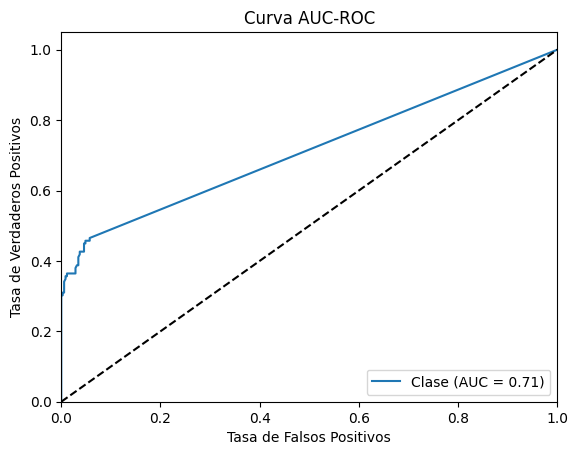

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad del modelo
y_true = [1 if x>0 else 0 for x in df_total['class_x']]
y_pred_proba = df_total['conf']

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Clase (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Show dataframe from class_x class_y